In [2]:
%matplotlib notebook

# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import pandas as pd

import colony_iomethods as cm
import tracker as tr

from matplotlib import pyplot as plt

In [3]:
# Folder for the files
exp_name = "EQ59_Gly_02022021"
acq_name = "TileScan_Tp11-24"
channel_str = "_ch00"

base_folder = f"D:/Tolga/Colony Images/{exp_name}/{exp_name}_{acq_name}/"
# base_folder = f"E:/Tolga/{exp_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Merged images folder
merged_folder = base_folder + "ch00/Merged/"
# Video folder
# video_folder = base_folder + "Videos_Marked/"
video_folder = base_folder + "ch00/Videos_Unmarked/"

In [4]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tilescan is set


## Important!! 
### Each frame is scaled from a tilescan of 1024x1024 images, to a final 512x512 in the video.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly


In [5]:
tilescan_desc = cm.collectTileScan(image_xml)

tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]

scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

tilescan is set


## Collect image sequence from 512x512 videos

In [6]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, acq_name, t_str):
    # Run through a single timepoint
    video_path = video_folder + f"{exp_name}_{acq_name}_{t_str}.avi"

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count), np.uint8)
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq

# frame info from test file

t_str = "t03"
video_path = video_folder + f"{exp_name}_{acq_name}_{t_str}.avi"
vidcap = cv2.VideoCapture(video_path)

# Frame properties
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

In [7]:
frame_count

235

## Interactive plot for locating center

<IPython.core.display.Javascript object>


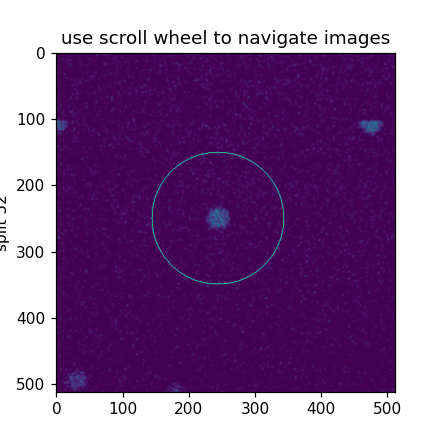

In [10]:
centerx = 244
centery = 249


zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_folder, acq_name, t_str)
img_seq_maxz = np.zeros((frame_height, frame_width, len(zar))) # numpy 3d array image sequence to track max intensity images
for zix in range(len(zar)):
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (5,5), 0).astype(np.uint8)
    equalized_image = cv2.equalizeHist(blurred_image)
    ret, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
#     # Use threshold_image for manually measuring the radius and the center
#     img_seq_maxz[:, :, tix] = threshold_image
    # Use blurred_image for nice plots
    cv2.circle(blurred_image, (centerx, centery), 100, (255,255,255), 1)
    img_seq_maxz[:, :, zix] = blurred_image
        

# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots(1, 1, figsize=(4,4))
tracker = tr.IndexTracker(ax, img_seq_maxz, 52)#, args_dict)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [11]:
img = img_seq[:,:,75]
radius = 100
circle_img = np.zeros((frame_height,frame_width), np.uint8)
cv2.circle(circle_img,(int(centerx),int(centery)), radius,1,thickness=-1)
masked_data = cv2.bitwise_and(img, img, mask=circle_img)
flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))

masked_mean = masked_data.sum()/circle_img.sum()
flip_masked_mean = flip_masked_data.sum()/(1-circle_img).sum()

display(masked_mean)
display(flip_masked_mean)
display(img.mean())


1.9033644205366522

1.7671750597025921

1.7834968566894531

## Run through each frame and reduce the frames in the video based on the threshold

In [12]:
# LxL blocks
pxl_threshold = 80
cnt_threshold = 3
block_length = 5

# reduced_height = int(frame_height/block_length)
# reduced_width = int(frame_width/block_length)

(reduced_height, reduced_width) = (512,512)
# zix = 55 # z index
# This part could be more efficient using built-in python capabilities
Rar_pxl = np.arange(2,int(reduced_height/2), dtype=np.int) # radius in pixels
central_average = np.zeros((len(Rar_pxl),frame_count), dtype=np.double)

for zix in range(frame_count):
    print("\rCalculating %d/%d..." % (zix, frame_count), end="")
    sys.stdout.flush()
    
    blurred_img = cv2.blur(img_seq[:,:,zix], (15,15))
    _, threshold_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)
#     reduced_avg_img = np.zeros((int(frame_height/block_length), 
#                         int(frame_width/block_length)))
#     reduced_cnt_img = np.zeros((int(frame_height/block_length), 
#                         int(frame_width/block_length)))
#     for yix in range(len(reduced_avg_img)):
#         for xix in range(len(reduced_avg_img[yix])):
#             block_img = img_seq[yix*block_length:(yix+1)*block_length,
#                                 xix*block_length:(xix+1)*block_length,
#                                 zix]
#             reduced_avg_img[yix,xix] = block_img.mean()
#             reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
            
    
#     img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
    img = threshold_img
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((512,512), np.uint8)
        cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(img, img, mask=circle_img)

        central_average[Rix, zix] = masked_data.sum()

Calculating 234/235...

In [13]:
threshold_img.shape

(512, 512)

<IPython.core.display.Javascript object>


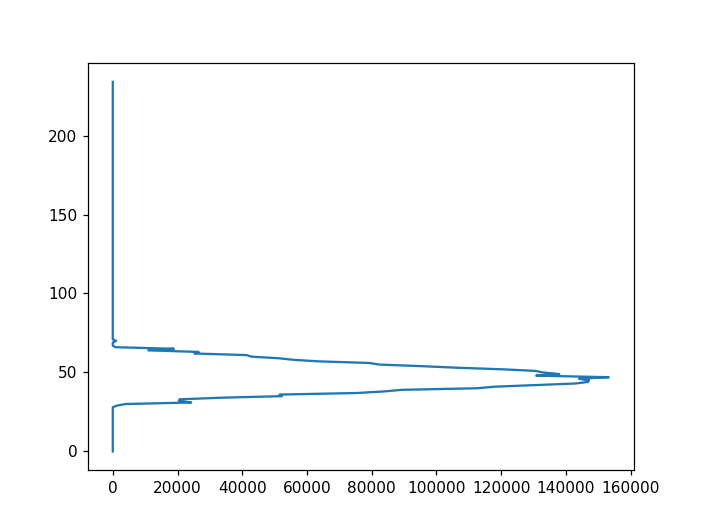

In [14]:
fig, ax = plt.subplots(1,1)
# ax.plot(Rar_pxl, central_average[:,120])
radz = Rar_pxl[np.argmax(central_average,axis=0)]
# ax.plot(zar, radz, 'o')
ax.plot(np.max(central_average,axis=0), zar)

### Reduced images from the frames of the videos

Calculating 50/235...

<IPython.core.display.Javascript object>


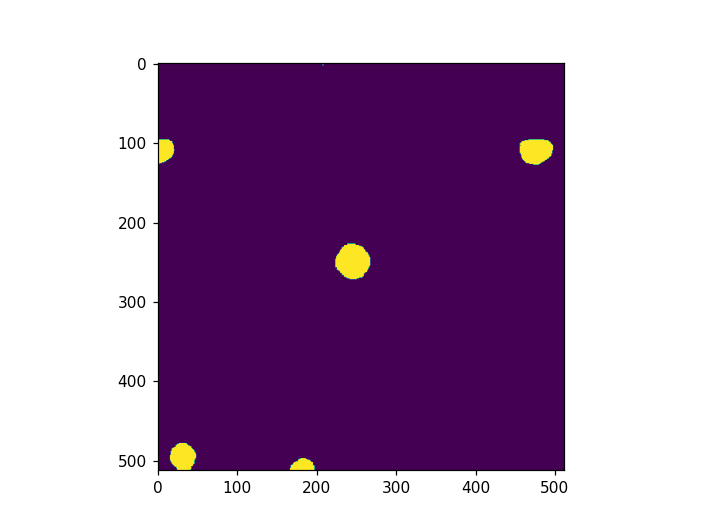

In [19]:
# Calculate circular average
# LxL blocks
pxl_threshold = 30
cnt_threshold = 3
block_length = 5

reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

zix = 50
print("\rCalculating %d/%d..." % (zix, frame_count), end="")
sys.stdout.flush()
reduced_avg_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
reduced_cnt_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
img_seq = get_image_sequence(video_folder, acq_name, "t03")
# for yix in range(len(reduced_avg_img)):
#     for xix in range(len(reduced_avg_img[yix])):
#         block_img = img_seq[yix*block_length:(yix+1)*block_length,
#                             xix*block_length:(xix+1)*block_length,
#                             zix]
#         reduced_avg_img[yix,xix] = block_img.mean()
#         reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
    
# fig,ax = plt.subplots(1,1)
# ax.imshow(reduced_cnt_img > cnt_threshold)

img = img_seq[:,:,zix]
# gray_img = cv2.cvtColor(img, cv2.)
blurred_img = cv2.blur(img, (15,15))
_, threshold_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)
# cv2.findContours(threshold_img, )
fig,ax = plt.subplots(1,1)
# ax.hist(blurred_img[blurred_img>3].flatten(), 150)
ax.imshow(threshold_img)

### Check the central_sum function for the given params

<IPython.core.display.Javascript object>


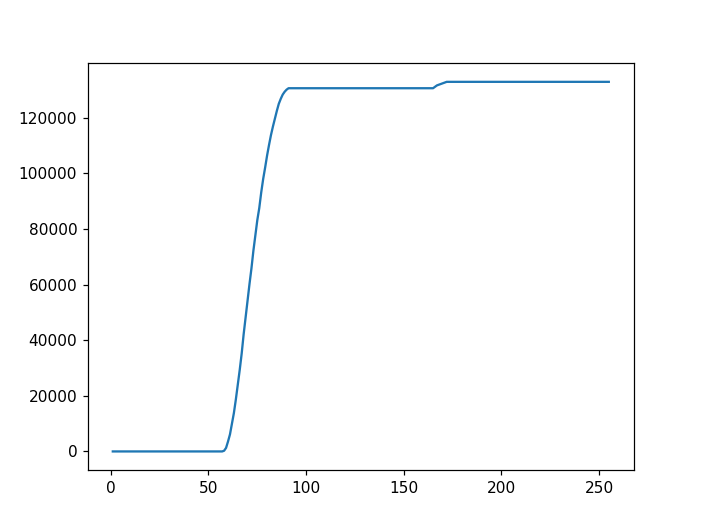

175

In [21]:
# img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
img = threshold_img
(reduced_height, reduced_width) = img.shape

Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

for Rix in range(len(Rar_pxl)):
    radius = Rar_pxl[Rix]

    circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
    cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)

    central_sum[Rix] = masked_data.sum()
    
# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl, central_sum)

# edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
edge_pxl = Rar_pxl[np.argmin(np.diff(uniform_fit))]
edge_pxl

### Central average throughout all scanning direcions (z and t)

In [23]:
# Calculate circular average
# LxL blocks
zar = np.arange(0,frame_count)
tar = np.arange(0,14)
# tar = np.array([7])
outer_radius_ar = np.zeros((len(tar), len(zar)))
masked_mean = np.zeros_like(outer_radius_ar)
flip_masked_mean = np.zeros_like(outer_radius_ar)
unmasked_mean = np.zeros_like(outer_radius_ar)
for tix in range(len(tar)):
    t_str = "t%02d" % tar[tix]
    print(t_str)
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        zstrix = zar[zix]
        z_str = "z%03d" % (zstrix)

        print("\rCalculating %d/%d for tix=%d/%d" % (zstrix, frame_count, tix, len(tar)), end="")
        sys.stdout.flush()

#         reduced_avg_img = np.zeros((reduced_height, reduced_width))
#         reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)

#         for yix in range(len(reduced_avg_img)):
#             for xix in range(len(reduced_avg_img[yix])):
#                 block_img = img_seq[yix*block_length:(yix+1)*block_length,
#                                     xix*block_length:(xix+1)*block_length,
#                                     zix]
#                 reduced_avg_img[yix,xix] = block_img.mean()
#                 reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()

#         img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
        
        blurred_img = cv2.blur(img_seq[:,:,zix], (15,15))
        _, threshold_img = cv2.threshold(blurred_img, 10, 255, cv2.THRESH_BINARY)
        img = threshold_img
        
        (reduced_height, reduced_width) = img.shape

        Rar_pxl = np.arange(1,int(reduced_height), dtype=np.int) # radius in pixels
        central_sum = np.zeros_like(Rar_pxl, dtype=np.double)        
        
        # Calculate central sum: the sum of intensity of each pixel inside a circle
        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]

            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)

            central_sum[Rix] = masked_data.sum()


        # Calculate the uniform fit (polyfit with degree=0)
        uniform_fit = np.zeros_like(Rar_pxl[:-1])
        for ix in range(len(Rar_pxl[:-1])):
            edge_ix = Rar_pxl[ix]
            uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
        try:
#             outer_radius_ar[tix, zix] = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
            outer_radius_ar[tix,zix] = Rar_pxl[np.argmin(np.diff(uniform_fit))]
            radius = np.uint8(outer_radius_ar[tix,zix])
            
            full_img = img_seq[:,:,zix]
            full_circle_img = np.zeros((frame_height, frame_width), np.uint8)
            cv2.circle(full_circle_img, (centerx, centery), int(radius*block_length), 1, thickness=-1)
            
            masked_data = cv2.bitwise_and(full_img, full_img, mask=full_circle_img)
            flip_masked_data = cv2.bitwise_and(full_img, full_img, mask=(1-full_circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/full_circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-full_circle_img).sum()
            unmasked_mean[tix,zix] = full_img.mean()
        except IndexError:
            print("Index Error")
            outer_radius_ar[tix, zix] = 0
            radius = 0
            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius ,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)
            flip_masked_data = cv2.bitwise_and(img, img, mask=(1-circle_img))
            
            masked_mean[tix,zix] = np.double(masked_data.sum())/circle_img.sum()
            flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-circle_img).sum()
            unmasked_mean[tix,zix] = img.mean()

t00
Calculating 26/235 for tix=0/14

<ipython-input-23-87e34efbf0e4>:72: RuntimeWarning: invalid value encountered in double_scalars
  flip_masked_mean[tix,zix] = np.double(flip_masked_data.sum())/(1-full_circle_img).sum()


Calculating 234/235 for tix=0/14t01
Calculating 234/235 for tix=1/14t02
Calculating 234/235 for tix=2/14t03
Calculating 234/235 for tix=3/14t04
Calculating 234/235 for tix=4/14t05
Calculating 234/235 for tix=5/14t06
Calculating 234/235 for tix=6/14t07
Calculating 234/235 for tix=7/14t08
Calculating 234/235 for tix=8/14t09
Calculating 234/235 for tix=9/14t10
Calculating 234/235 for tix=10/14t11
Calculating 234/235 for tix=11/14t12
Calculating 234/235 for tix=12/14t13
Calculating 234/235 for tix=13/14

In [32]:
outer_radius_mm = xsz*tile_xcnt/reduced_height*xvoxel*outer_radius_ar/1e3
zar_mm = zar*zvoxel
df_dict = {"zar (mm)": zar_mm}
for tix in range(len(tar)):
    t_str = "t%02d" % (tix)
    df_dict[f"rad_{t_str} (mm)"] = outer_radius_mm[tix,:]
    df_dict[f"mean_{t_str}"] = unmasked_mean[tix,:]
    df_dict[f"col_mean_{t_str}"] = masked_mean[tix,:]
    df_dict[f"bg_mean_{t_str}"] = flip_masked_mean[tix,:]
    
df = pd.DataFrame(data = df_dict)
df.to_csv(base_folder + f"ch00/Resources/{acq_name}_Movie.csv")

df_metadata = pd.DataFrame({"type": "Movie",
                            "pxl_threshold": pxl_threshold,
                            "cnt_threshold": cnt_threshold,
                            "centerx": centerx,
                            "centery": centery,
                            "block_length": block_length},
                           index = [0])
df_metadata.to_csv(base_folder + f"ch00/Resources/{acq_name}_Movie_Metadata.csv")

In [33]:
df

,zar (mm),rad_t00 (mm),mean_t00,col_mean_t00,bg_mean_t00,rad_t01 (mm),mean_t01,col_mean_t01,bg_mean_t01,rad_t02 (mm),...,col_mean_t11,bg_mean_t11,rad_t12 (mm),mean_t12,col_mean_t12,bg_mean_t12,rad_t13 (mm),mean_t13,col_mean_t13,bg_mean_t13
0,-0.000,0.00909,0.690632,0.000000,0.690845,0.00909,1.024002,0.888889,1.024044,0.00909,...,3.555556,1.215009,0.00909,1.271843,3.617284,1.271118,0.00909,1.274464,4.061728,1.273602
1,-0.004,0.00909,0.857269,1.074074,0.857202,0.00909,0.951813,0.518519,0.951947,0.00909,...,8.123457,1.201955,0.00909,1.274208,2.358025,1.273873,0.00909,1.297386,2.481481,1.297020
2,-0.008,0.00909,0.840244,0.061728,0.840485,0.00909,0.962692,4.604938,0.961566,0.00909,...,3.666667,1.160408,0.00909,1.192997,4.493827,1.191977,0.00909,1.203857,7.481481,1.201917
3,-0.012,0.00909,0.846169,2.506173,0.845655,0.00909,0.920357,6.222222,0.918718,0.00909,...,1.108280,NaN,0.00909,1.138775,1.592593,1.138635,0.00909,1.194202,3.172840,1.193591
4,-0.016,0.00909,0.897511,3.419753,0.896731,0.00909,0.928288,2.617284,0.927765,0.00909,...,1.155327,NaN,4.38138,1.137661,1.137661,NaN,4.22685,1.168213,1.168213,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,-0.920,0.00909,2.044437,0.333333,2.044966,0.00909,2.024651,6.308642,2.023326,0.00909,...,6.444444,2.644311,0.00909,2.827000,5.049383,2.826313,0.00909,3.001808,3.000000,3.001809
231,-0.924,0.00909,2.026531,0.975309,2.026856,0.00909,2.039898,1.679012,2.040009,0.00909,...,4.506173,2.682042,0.00909,2.819099,0.666667,2.819765,1.33623,3.038956,3.038956,NaN
232,-0.928,0.00909,1.999744,1.802469,1.999805,0.00909,2.070133,0.172840,2.070720,0.00909,...,4.382716,2.682034,0.00909,2.858757,2.000000,2.859022,0.00909,2.970901,3.950617,2.970599
233,-0.932,0.00909,1.984734,1.950617,1.984744,0.00909,2.076118,1.765432,2.076214,0.00909,...,1.580247,2.720426,0.00909,2.824486,3.518519,2.824271,0.00909,2.982967,1.333333,2.983477


<IPython.core.display.Javascript object>


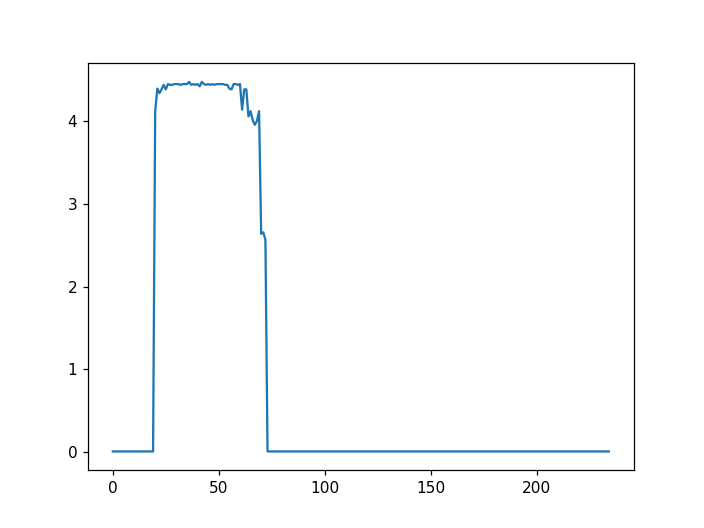

In [26]:
# df.plot(x="zar (mm)", y="bg_mean_t00")
fig,ax = plt.subplots(1,1)
ax.plot(zar, outer_radius_mm[3,:])
# ax.imshow(circle_img)
# csv_path

(14, 235)


<IPython.core.display.Javascript object>


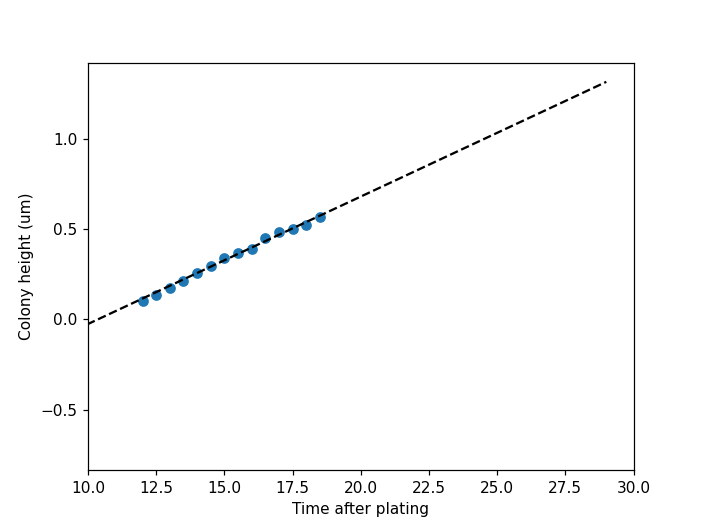

array([ 0.07062937, -0.73141259])

In [28]:
print(outer_radius_ar.shape)
tar = np.arange(0,14)
height = np.zeros_like(tar)
for tix in range(len(tar)):
    height[tix] = (outer_radius_ar[tix,:]>2).sum()
    
t = tar/2 + 12
h = -height*zvoxel
fig,ax = plt.subplots(1,1, dpi=100)
ax.plot(t, h, 'o')
ax.set_xlim(10,30)
# ax.set_ylim(0,4)
ax.set_xlabel(r'Time after plating')
ax.set_ylabel(r'Colony height (um)')

p = np.polyfit(t[2:],h[2:],1)
tt = np.arange(0,30)
hh = p[0]*tt + p[1]
ax.plot(tt,hh, 'k--')
p

In [29]:
h

array([0.104, 0.136, 0.176, 0.212, 0.26 , 0.296, 0.34 , 0.368, 0.392,
       0.452, 0.484, 0.5  , 0.524, 0.568])

In [ ]:
# df.plot(x="zar (mm)", y="bg_mean_t00")

fig,ax = plt.subplots(1,1)
zar = df["zar (mm)"]
ax.plot(zar, df["bg_mean_t00"],
       zar, df["bg_mean_t01"],
       zar, df["bg_mean_t02"],
       zar, df["bg_mean_t03"],
       zar, df["bg_mean_t04"],
       zar, df["bg_mean_t05"],
       zar, df["bg_mean_t06"],
       zar, df["bg_mean_t07"])

In [ ]:
flip_masked_mean.dtype

In [ ]:
df.plot(x="zar (mm)", y="col_mean_t01")